### Задача — разработать модель, которая позволила бы обойти конкурентов по скорости и качеству совершения сделок.

### **Что необходимо сделать:** разработать сервис для предсказания стоимости домов на основе истории предложений.

Импортируем библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from scipy import stats
import optuna
from catboost import CatBoostRegressor
from datetime import date
import statsmodels.api as sm
from statsmodels import stats as sms
import re
import warnings
import pickle
warnings.filterwarnings('ignore')


Загрузим датасет.

In [2]:
data = pd.read_csv('data/data.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


##### <center>**Признаки**

* status - статус лота
* private pool и PrivatePool - наличие бассейна,
* propertyType - тип недвижимости
* street - адрес
* baths - количество ванных комнат
* homeFacts - дополнительные сведения о недвижимости
* fireplace - сведения о наличии и типе камина
* city - город в котором находится лот
* schools - данные о рейтинге и местоположении ближайших школ
* sqft - площадь лота в квадратных футах
* zipcode - почтовый индекс
* beds - количество спален в доме
* state - штат в котом находится лот
* stories - количество этажей
* mls-id и MlsId - идентификатор MLS (Multiple Listing Service - Служба множественного листинга)
* target - цена недвижимости - целевой признак, который необходимо спрогнозировать

Информация о признаках в датасете.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Имеются пропуски и все признаки имеют формат object.

Выведим описательную статистику признаков.

In [4]:
data.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103114,377151,377185,336608,377185,285903,377185,226469,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1652,2026,297365,25405,4549,1184,39,347,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


Выведим количество пропусков в признаках.

In [5]:
data.isnull().sum()

status           39918
private pool    373004
propertyType     34733
street               2
baths           106338
homeFacts            0
fireplace       274071
city                34
schools              0
sqft             40577
zipcode              0
beds             91282
state                0
stories         150716
mls-id          352243
PrivatePool     336874
MlsId            66880
target            2481
dtype: int64

Удалим записи с пропусками в целевом столбце.

In [6]:
print('Количество записей в таблице до удаления пропусков: {}'.format(data.shape[0]))
data.dropna(axis=0,subset=['target'],inplace=True)
print('Количество записей в таблице после удаления пропусков: {}'.format(data.shape[0]))

Количество записей в таблице до удаления пропусков: 377185
Количество записей в таблице после удаления пропусков: 374704


Проверим данные на наличие дубликатов, если дубликаты есть удалим их.

In [7]:
print('Количество дубликатов в таблице: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов в таблице: 49


In [8]:
data.drop_duplicates(inplace=True)
print('Количество записей в таблице после удаления дубликатов: {}'.format(data.shape[0]))

Количество записей в таблице после удаления дубликатов: 374655


##### С помощью функций произведём предобработку признаков.

Приведём целевой столбец к числовому типу, для этого удалим все знаки не являющиеся цифрами.

In [10]:
def get_target_num(arg):
    arg = arg.replace(' ','').replace('$','').replace(',','').replace('+','').replace('-','').replace('/','')
    arg = re.sub(r'[A-Za-z]','',arg)
    arg = arg.split('-')
    result = arg[0]
    return result

Применяем функцию и меняем тип данных на числовой.

In [11]:
data['target'] = data['target'].apply(get_target_num)
data['target'] = data['target'].astype(float)

Структурируем столбец о статусе лота по категориям.

In [12]:
def get_new_status(arg):
    for_sale = ['for']
    active = ['active', 'a', 'active/contingent']
    fore_closure = ['foreclosure', 'auction', 'foreclosed', 'pre-foreclosure']
    pending = ['p', 'pending']
    contract = ['under', 'c']
    new = ['new', 'n']
    back_change = ['back','change']
    rent = ['rent']
    coming_soon = ['coming']
    splitted_st = arg.lower().split(' ')
    for i in splitted_st:
        if i in active:
            return 'active'
        elif i in for_sale:
            return 'for sale'
        elif i in fore_closure:
            return 'foreclosure'
        elif i in pending:
            return 'pending'
        elif i in new:
            return 'new'
        elif i in back_change:
            return 'back changes'
        elif i in rent:
            return 'rent'
        elif i in contract: 
            return 'contract'
        elif i in coming_soon: 
            return 'coming soon'
        else:
            return 'other'

Меняем тип данных на строку и применяем функцию.

In [13]:
data['status'] = data['status'].astype(str)
data['status'] = data['status'].apply(get_new_status)

Признаки PrivatePool и private pool содержат информацию о наличии бассейна, но информация в них не совпадает. Преобразуем данные в обоих столбцах к бинарному виду: 1 - бассейн есть, 0 - бассейна нет и объединяем оба столбца в один столбец - pool

In [14]:
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: 1 if x == 'Yes' or x == 'yes' else 0)
data['private pool'] = data['private pool'].apply(lambda x: 1 if x == 'Yes' or x == 'yes' else 0)

data['pool'] = data.apply(lambda x: (max(x['PrivatePool'], x['private pool'])), axis=1)

Удаляем признаки PrivatePool и private pool.

In [15]:
data.drop(['PrivatePool','private pool'], axis=1, inplace=True)

Преобразуем признак о типах недвижимости.

In [16]:
def get_type(arg):
    Single_family = ['single-family home', 'Single Family', 'Single Family Home', 'Detached', 'Tiny Home', 'Single Detached', 'SingleFamilyResidence', 'Single Detached, Traditional']
    Multi_family = ['multi-family', 'Multi Family', 'Multi-Family Home', 'Multiple Occupancy']
    Land = ['lot/land', 'land']
    Townhouse = ['townhouse', 'Townhouse', 'Townhome']
    Condo = ['Condo', 'condo', 'coop', 'Condo/Townhome', 'Cooperative', 'Condo/Townhome/Row Home/Co-Op']
    if arg in Single_family:
        arg = 'Single Family'
    elif arg in Multi_family:
        arg = 'Multi_family'
    elif arg in Land:
        arg = 'Land'
    elif arg in Townhouse:
        arg = 'Townhouse'
    elif arg in Condo:
        arg = 'Condo'
    else:
        arg = 'Other'
    return arg

Применяем функцию.

In [17]:
data['propertyType'] = data['propertyType'].apply(get_type)

Преобразуем столбец с данными о количестве ванных комнат.

In [18]:
def get_bathrooms(arg):
    if isinstance(arg,float):
        return arg
    if arg is np.nan or arg is '' or arg is 'none' or arg is 'no data' or arg is '-':
        return np.nan
    if isinstance(arg,str):
        arg = arg.replace(' ','').replace('+','').replace(',','.').replace('~','').replace(':','')
        arg = re.sub(r'[A-Za-z]','',arg)
        arg = arg.replace('..','')
        list_1 = arg.split('-')
        arg = list_1[0]
        arg = arg.replace('—','')
        list_2 = arg.split('/')
        arg = list_2[0]
        if arg != '':
            return arg
        else:
            return np.nan

применяем функцию и меняем тип данных на числовой.

In [19]:
data['baths'] = data['baths'].apply(get_bathrooms)
data['baths'] = data['baths'].astype(float)

Попробуем получить дополнительную информацию из столбца homeFacts.

In [21]:
def get_cleaned_facts(arg):
    #Переводим строку в нижний регистр
    arg = str(arg).lower()
    # Удаляем запятые между цифрами
    arg = re.sub(r'(\d),(\d)', r'\1\2', arg)
    # Удаляем '$'
    arg = arg.replace('$', '')
    # Удаляем ' sqft', ' sq. ft.' и ' acres'
    arg = arg.replace(' sqft', '')
    arg = arg.replace('/sqft', '')
    arg = arg.replace(' sq. ft.', '')
    # Удаляем ' lot', ' acre' и 'contact manager'
    arg = arg.replace(' lot', '')
    arg = arg.replace(' acres', '')
    arg = arg.replace(' acre', '')
    arg = arg.replace('contact manager', '')
    # Удаляем ' /', '—', '-' и 'no info' 
    arg = arg.replace('—', '')
    arg = arg.replace('-', '')
    arg = arg.replace(' /', '')
    arg = arg.replace('no info', '')
    return arg

In [22]:
data['homeFacts'] = data['homeFacts'].apply(lambda x: str(x).lower())

for i, row in data.iterrows():
    home_facts = row['homeFacts']
    home_facts = get_cleaned_facts(home_facts)
    data.at[i, 'homeFacts'] = home_facts
# Задаем регулярное выражение для поиска пары ключ-значение
pattern = r"{'factvalue': '(.*?)', 'factlabel': '(.*?)'}"
# Проходим циклом по всем строкам столбца 'homeFacts'
for i, row in data.iterrows():
    home_facts_str = row['homeFacts']
    #Находим пару ключ-значение
    matches = re.finditer(pattern, home_facts_str)
    home_facts = {}
    for match in matches:
        factvalue = match.group(1)
        factlabel = match.group(2)
        home_facts[factlabel] = factvalue
    # Обновляем значение в столбце и переводим к типам:'year_built' и 'remodeled year' - int
    year_of_built = home_facts.get('year built', None)
    if year_of_built is None or year_of_built == 'no data' or year_of_built == '':
        data.at[i, 'year_of_built'] = None
    else:
        data.at[i, 'year_of_built'] = int(year_of_built)
    remodeled_year = home_facts.get('remodeled year', None)
    if remodeled_year is None or remodeled_year == 'no data' or remodeled_year == '':
        data.at[i, 'remodeled year'] = None
    else:
        data.at[i, 'remodeled year'] = int(remodeled_year)
    # 'heating', 'cooling', 'parking' - str
    data.at[i, 'heating'] = home_facts.get('heating', None)
    data.at[i, 'cooling'] = home_facts.get('cooling', None)
    data.at[i, 'parking'] = home_facts.get('parking', None)
    # 'lotsize', ' price' - float
    lot_size = home_facts.get('lotsize', None)
    if lot_size is None or lot_size == 'no data' or lot_size == '':
        data.at[i, 'lotsize'] = None
    else:
        data.at[i, 'lotsize'] = float(lot_size)
    price_sqft = home_facts.get('price', None)
    if price_sqft is None or price_sqft == 'no data' or price_sqft == '':
        data.at[i, 'price'] = None
    else:
        data.at[i, 'price'] = float(price_sqft)

In [23]:
data['lotsize'] = data['lotsize'].astype(float)

После преобразования столбца homeFacts мы получили дополнительные признаки содержащие информацию о годе постройки(year_of_built), годе капитального ремонта(remodeled year), отоплении(heating), кондиционировании(cooling), наличии парковочного места(parking), размере лота(lotsize), цене лота(price).

Удоляем столбец homeFacts.

In [23]:
data.drop('homeFacts',axis=1,inplace=True)

Заменим признак year_of_built(год постройки) на age_building(возраст здания)

In [24]:
today = date.today()
this_year = today.year
data['age_building'] = this_year - data['year_of_built']
data = data[data['age_building'] >= 0]

data.drop('year_of_built', axis=1, inplace=True)

Получим информацию о близлежащих школах и добавим столбцы со средним рейтингом и средним расстоянием до школы.

In [25]:
def get_distance(arg):
    pattern = r"Distance': \['(.+?)'\], 'Grades'"
    match = re.search(pattern, arg)
    if match:
        return match.group(1)
    else:
        return None

In [26]:
data['distance_to_schools'] = data['schools'].apply(get_distance)
data['distance_to_schools'] = data['distance_to_schools'].astype(str)
data['distance_to_schools'] = data['distance_to_schools'].apply(lambda x: re.sub(r'\smi', '', x))
data['distance_to_schools'] = data['distance_to_schools'].str.replace(r'[^\d.,\s]', '', regex=True)
data['distance_to_schools'] = data['distance_to_schools'].apply(lambda x: [float(num) for num in x.split(',')] if x else [])
data['distance_to_schools_avg'] = data['distance_to_schools'].apply(lambda x: round(sum(x)/len(x), 2) if x else 0)

In [27]:
data['schools'] = data['schools'].astype(str)
data['schools_rating'] = data['schools'].apply(lambda x: re.sub(r'data.*', '', x))
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'/10', '', x))
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'[^\w\s,]', '', x))
data['schools_rating'] = data['schools_rating'].apply(lambda x: x.replace('rating', ''))
data['schools_rating'] = data['schools_rating'].apply(lambda x: x[:-2])
data['schools_rating'] = data['schools_rating'].apply(lambda x: x[1:])
# Создаем столбец 'school_count'
data['school_count'] = data['schools_rating'].apply(lambda x: (len(x.split(','))) if x != '' else 0)
data['school_count'] = data['school_count'].astype('int')
# Удаляем все символы, кроме цифр
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'[a-zA-Z]', '', x))
data['schools_rating'] = data['schools_rating'].apply(lambda x: re.sub(r'\s+,', '', x))
data['schools_rating'] = data['schools_rating'].apply(lambda x: x[:-1])
# Создаем столбец 'schools_rating_list'
data['schools_rating_list'] = data['schools_rating'].apply(lambda x: [int(i) for i in re.findall(r'\d+', x)])
# Создаем столбец 'schools_rating_ave'
data['schools_rating_avg'] = data['schools_rating_list'].apply(lambda x: round(sum(x) / len(x), 2) if len(x) > 0 else 0)
data['schools_rating_avg'] = data['schools_rating_avg'].apply(np.round, decimals=2)
avg = data['schools_rating_avg'].mean()
data['schools_rating_avg'] = data['schools_rating_avg'].apply(lambda x: avg if x < 1 else x)

Удаляем столбец schools и вспомогательные столбцы для рассчета среднего рейтинга и расстояния до школы.

In [28]:
data.drop(['schools', 'schools_rating_list', 'schools_rating', 'distance_to_schools'],axis=1, inplace=True)

Преобразуем столбцы fireplace, cooling, heating и parking к бинарному виду: 1 - если есть данные в столбце, 0 - если данных нет.

In [29]:
list_no_data = ['', 'no data', 'none', 'Not Applicable', 'No', ' ']
data['fireplace'] = data['fireplace'].apply(lambda x: 0 if x is np.nan or x in list_no_data  else 1)
data['cooling'] = data['cooling'].apply(lambda x: 0 if x is np.nan or x in list_no_data else 1)
data['heating'] = data['heating'].apply(lambda x: 0 if x is np.nan or x in list_no_data  else 1)
data['parking'] = data['parking'].apply(lambda x: 0 if x is np.nan or x in list_no_data  else 1)

Преобразуем столбец с данными о площади лота.

In [30]:
def get_numsqft(arg):
        if isinstance(arg, float):
            return arg
        if arg is np.nan or arg in ['', 'no data', 'none'] :
            return np.nan
        if isinstance(arg, str):
            S = re.sub(r'\D', '', arg)
            if S != '':
                return S
            else:
                return np.nan

In [31]:
data['sqft'] = data['sqft'].apply(get_numsqft)
data['sqft'] = data['sqft'].astype(float)

In [32]:
def get_bedrooms(arg):
    if isinstance(arg, float):
        return arg
    if arg is np.nan or arg is '' or arg is '—' or arg is 'no data' or arg is 'none':
        return np.nan
    if isinstance(arg, str):
        if (re.search(r'acre|acres|sqft|\$', arg)) is None:
            num = re.sub(r'[A-Za-z:+~#]', '', arg)
            num = num.replace(' ', '')
            num_list = num.split(',')
            num = num_list[0]
            num_list1 = num.split('-')
            num = num_list1[0]
            if num != '':
                return num
            else:
                return np.nan
        else:
            return np.nan  

In [33]:
data['beds'] = data['beds'].apply(get_bedrooms)
data['beds'] = data['beds'].astype(float)

Проверяем столбцы на наличие одинаковых значений.

In [34]:
low_information_cols = [] 

#цикл по всем столбцам
for col in data.columns:
    #наибольшая относительная частота в признаке
    top_freq = data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = data[col].nunique() / data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

mls-id: 99.87% уникальных значений


Столбцы mls-id и MlsID являются уникальными для каждого объекта недвижимости и не имеют никакого значения для предсказания стоимости, поэтому мы их удаляем.

In [27]:
data.drop(['mls-id','MlsId'], axis=1, inplace=True)
print(f'Итоговое число признаков: {data.shape[1]}')

Итоговое число признаков: 22


Удаляем столбцы не несущие для нас полезной информации.

In [36]:
data.drop(['zipcode', 'street', 'city',], axis=1, inplace=True)
print(f'Результирующее число признаков: {data.shape[1]}')

Результирующее число признаков: 20


Заполняем пропуски в данных средними значениями:

In [37]:
values = {
    'baths': data['baths'].mean(),
    'sqft': data['sqft'].mean(),
    'beds': data['beds'].mean(),
    'age_building': data['age_building'].mean()
}

data = data.fillna(values)

Удаляем столбцы, в которых более 30% пропусков и строки, в которых есть хотя бы один пропуск.

In [38]:
thresh = data.shape[0]*0.7
data = data.dropna(thresh=thresh, axis=1)
data = data.dropna(how='any')
print('Размерность таблицы: {}'.format(data.shape))

Размерность таблицы: (228390, 18)


### <center>Исследование и визуализация данных.

In [39]:
types = data.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['status', 'propertyType', 'state']

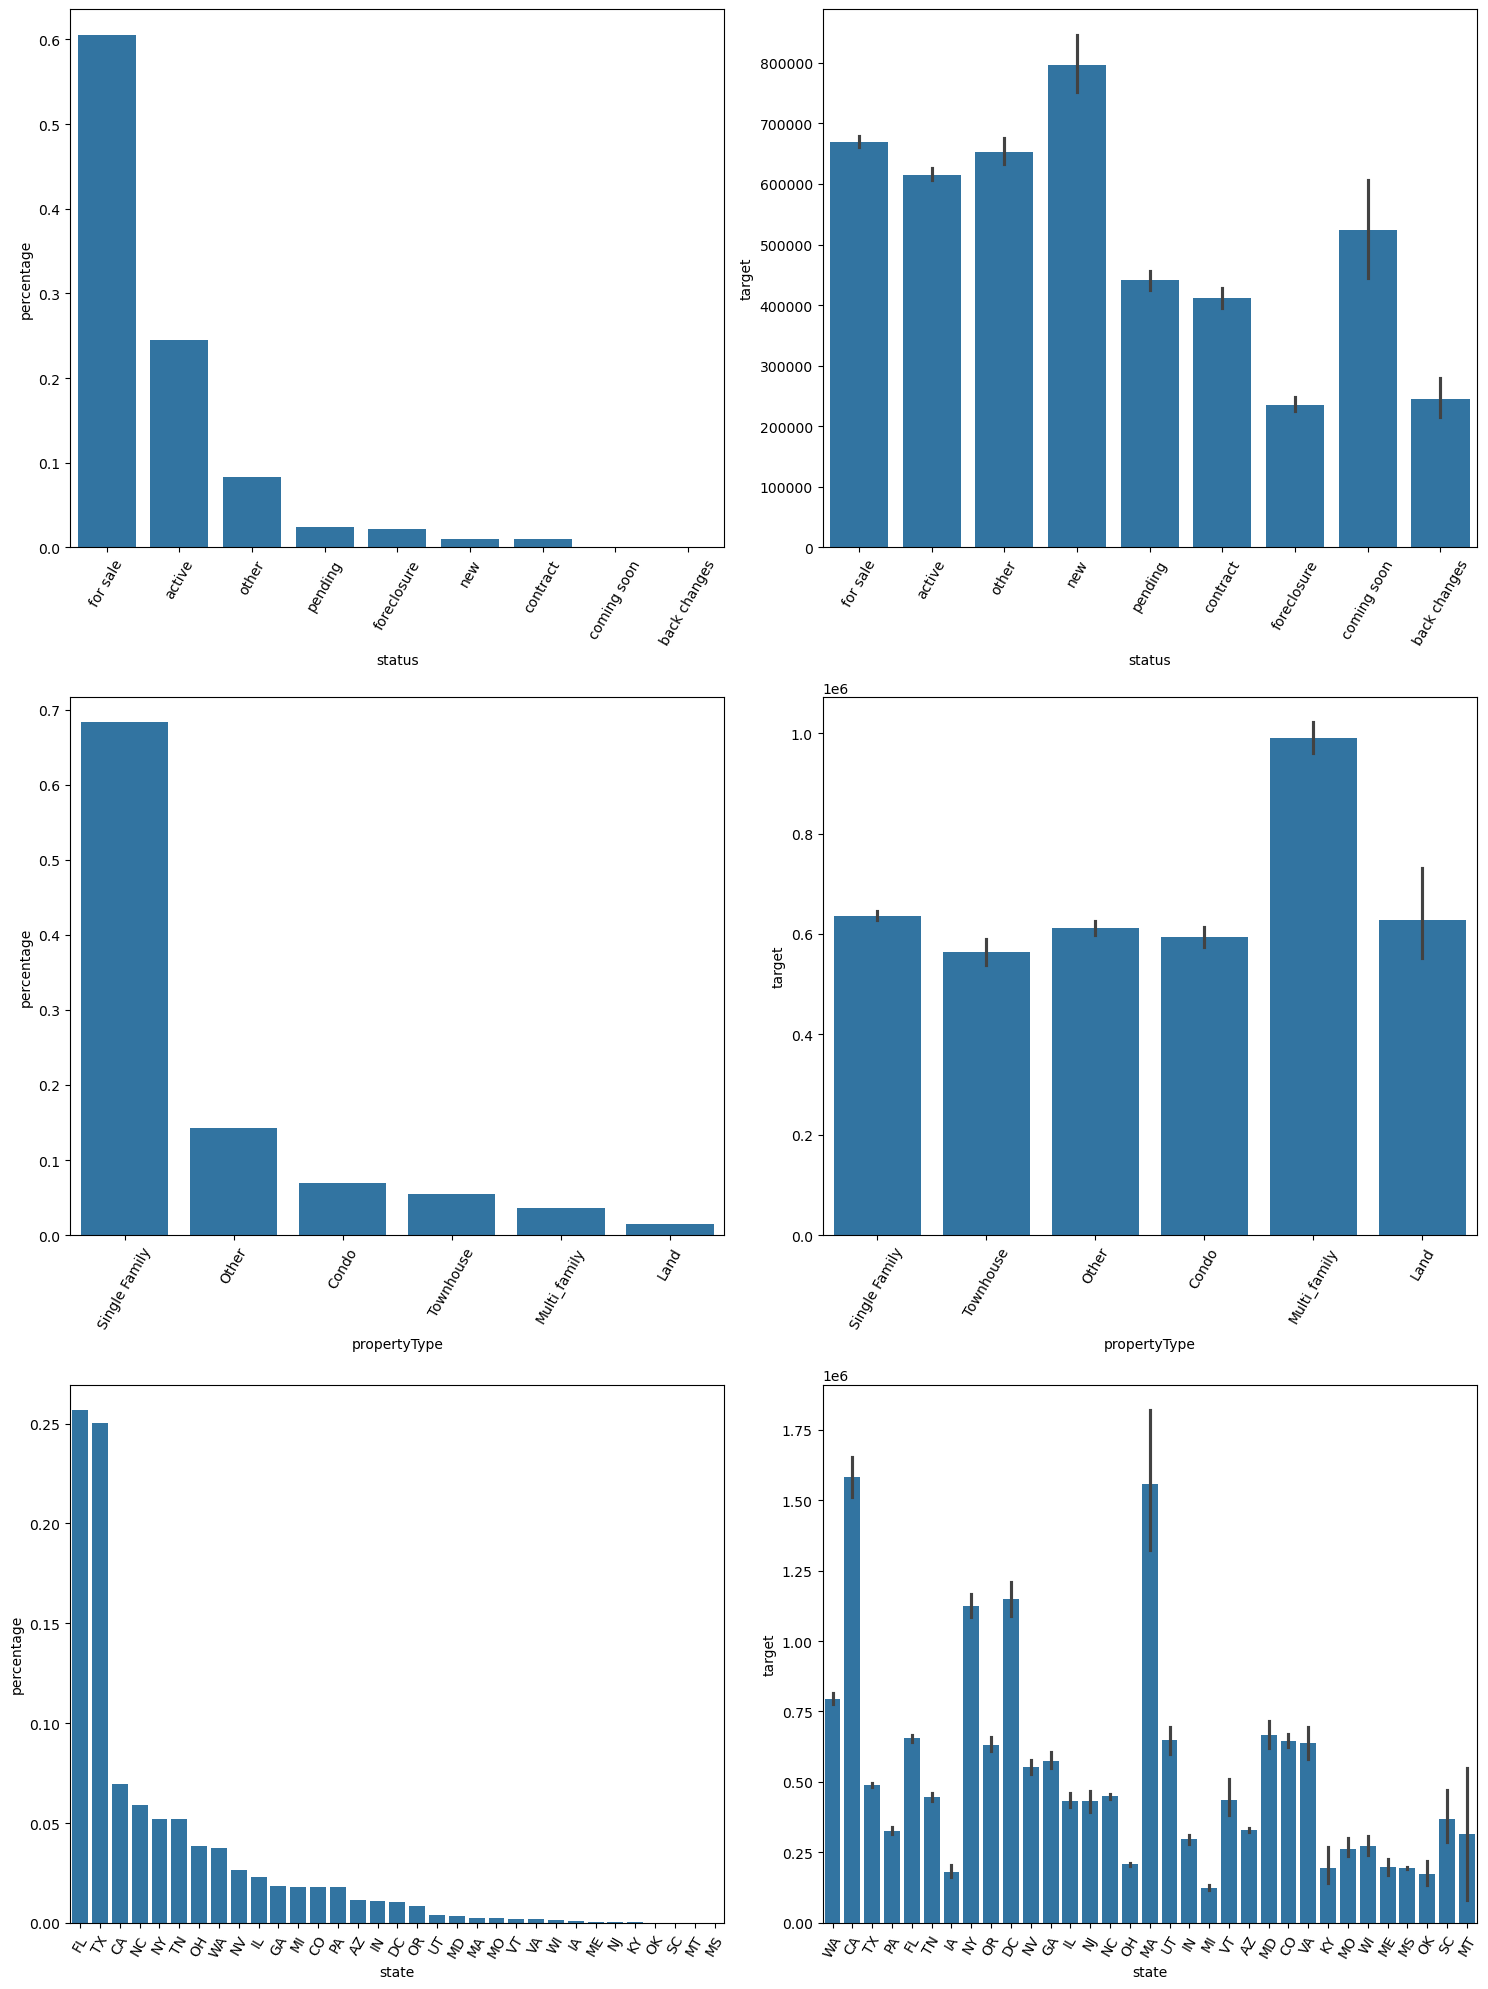

In [40]:
n = len(cat_features)
fig,axes = plt.subplots(n,2,figsize=(15,20))
for i,feature in enumerate(cat_features):
    count_data = (data[feature].value_counts(normalize=True).sort_values(ascending=False).rename('percentage').reset_index())
    count_barplot = sns.barplot(data=count_data,x=feature,y='percentage',ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    mean_barplot = sns.barplot(data=data,x=feature,y='target',ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout()

Произведем исследование логарифмированных распределений на наличие выбросов с помощью метода z-отклонений.

Построим график распределения целевой переменной и признака, отвечающего за площадь объекта в обычном и логарифмическом масштабе.

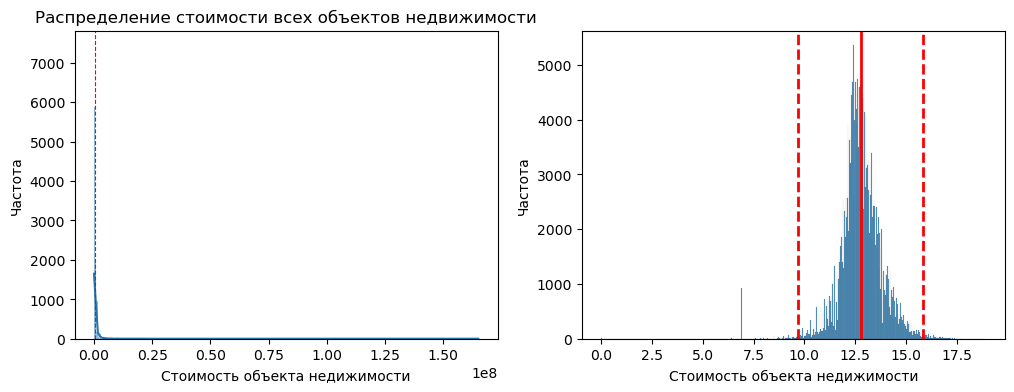

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(data['target'], kde=True, ax=axes[0])
axes[0].set(xlabel='Стоимость объекта недижимости', ylabel='Частота')
axes[0].set_title('Распределение стоимости всех объектов недвижимости')
axes[0].axvline(data['target'].mean(), color='red', linestyle='--', linewidth=0.8)
log_target = np.log(data['target'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_target, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].set(xlabel='Стоимость объекта недижимости', ylabel='Частота')
axes[1].axvline(log_target.mean(), color='red', lw=2)
axes[1].axvline(log_target.mean()+ 3 *log_target.std(),
                color='red', ls='--', lw=2)
axes[1].axvline(log_target.mean()- 3 *log_target.std(),
                color='red', ls='--', lw=2);

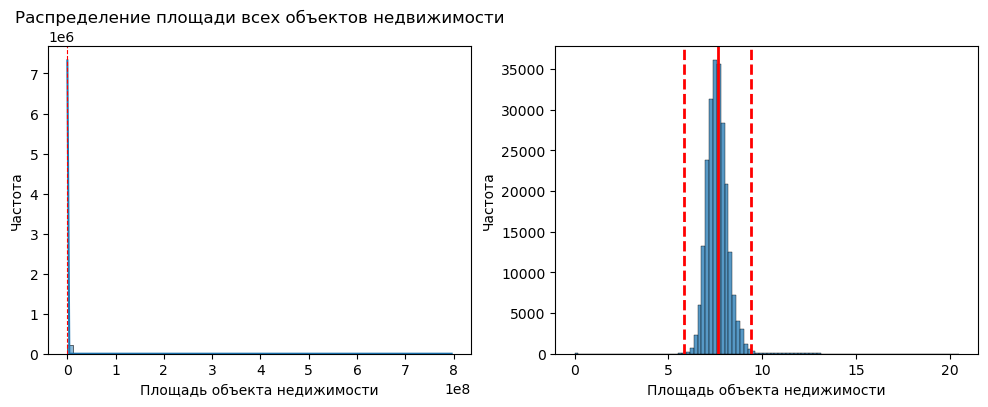

In [42]:
fig, axes = plt.subplots(1,2, figsize=(12, 4))
sns.histplot(data['sqft'], bins=70, kde=True, ax=axes[0])
axes[0].set(xlabel='Площадь объекта недижимости', ylabel='Частота')
axes[0].set_title('Распределение площади всех объектов недвижимости')
axes[0].axvline(data['sqft'].mean(), color='red', linestyle='--', linewidth=0.8)
log_sqft = np.log(data['sqft'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_sqft, bins=100, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].set(xlabel='Площадь объекта недижимости', ylabel='Частота')
axes[1].axvline(log_sqft.mean(), color='red', lw=2)
axes[1].axvline(log_sqft.mean()+ 3 *log_sqft.std(),
                color='red', ls='--', lw=2)
axes[1].axvline(log_sqft.mean()- 3 *log_sqft.std(),
                color='red', ls='--', lw=2);

Из графиков можно сделать вывод, что целевой признак и признак, отвечающий за площадь обекта не распределены нормально. Подтвердим визуальный вывод, проведя тест Шапиро-Уилка


Нулевая гипотеза ($H_0$): распределение данных является нормальным.

Альтернативная гипотеза ($H_1$): распределение данных отлично от нормального.

In [43]:
alpha = 0.05
print("Уровень значимости alpha = {:.2f}".format(alpha))

print('Целевой признак:')
_,p = stats.shapiro(data['target'])
print('p-value = %.2f'% (p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным.'.format(alpha))
    
print('Признак sqft:')
_,p = stats.shapiro(data['sqft'])
print('p-value = %.2f'% (p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным.'.format(alpha))

Уровень значимости alpha = 0.05
Целевой признак:
p-value = 0.00
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Признак sqft:
p-value = 0.00
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


Проверим гипотезу о том, что стоимость недвижимости с бассейном, чем стоимость недвижимости без него.

Сформулируем нулевую и альтернативные гипотезы

Нулевая гипотеза ($H_0$): стоимость дома с бассейном статистически меньше либо равна стоимости дома без бассейна.


Альтернативная гипотеза ($H_1$): стоимость дома с бассейном статистически больше, чем стоимость дома без бассейна.

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

Нулевая гипотеза ($H_0$): распределение данных является нормальным.

Альтернативная гипотеза ($H_1$): распределение данных отлично от нормального.

In [44]:
alpha = 0.05
print("Уровень значимости alpha = {:.2f}".format(alpha))

target_pool = data.loc[data['pool']==1, 'target']
target_notpool = data.loc[data['pool']==0, 'target']

print('Есть бассейн:')
_,p = stats.shapiro(target_pool)
print('p-value = %.2f'% (p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным.'.format(alpha))
    
print('Нет бассейна')
_,p = stats.shapiro(target_notpool)
print('p-value = %.2f'% (p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным.'.format(alpha))

Уровень значимости alpha = 0.05
Есть бассейн:
p-value = 0.00
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Нет бассейна
p-value = 0.00
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака «target»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному распределению? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

In [45]:
_, p = stats.mannwhitneyu(target_pool, target_notpool, alternative='greater')
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}.Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05.Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод:
Стоимость дома с бассейном больше, чем дома без бассейна

Проверим гипотезу о том, что стоимость недвижимости с камином больше, чем стоимость недвижимости без него.

Нулевая гипотеза ($H_0$): стоимость дома с камином статистически меньше либо равна стоимости дома без камина.


Альтернативная гипотеза ($H_1$): стоимость дома с камином статистически больше, чем стоимость дома без бассейна.

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

Нулевая гипотеза ($H_0$): распределение данных является нормальным.

Альтернативная гипотеза ($H_1$): распределение данных отлично от нормального.

In [46]:
alpha = 0.05
print("Уровень значимости alpha = {:.2f}".format(alpha))

target_fireplace = data.loc[data['fireplace']==1, 'target']
target_notfirepace = data.loc[data['fireplace']==0, 'target']

print('Есть камин:')
_,p = stats.shapiro(target_fireplace)
print('p-value = %.2f'% (p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным.'.format(alpha))
    
print('Нет камина')
_,p = stats.shapiro(target_notfirepace)
print('p-value = %.2f'% (p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным.'.format(alpha))

Уровень значимости alpha = 0.05
Есть камин:
p-value = 0.00
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Нет камина
p-value = 0.00
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака «target»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному распределению? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

In [47]:
_, p = stats.mannwhitneyu(target_fireplace, target_notfirepace, alternative='greater')
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}.Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05.Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод:
Стоимость дома с камином больше, чем дома без камина

Проверим гипотезу о том, что стоимость недвижимости с камином больше, чем стоимость недвижимости без него.

Нулевая гипотеза ($H_0$): стоимость дома с парковочным местом статистически меньше либо равна стоимости дома без камина.


Альтернативная гипотеза ($H_1$): стоимость дома с парковочным местом статистически больше, чем стоимость дома без бассейна.

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

Нулевая гипотеза ($H_0$): распределение данных является нормальным.

Альтернативная гипотеза ($H_1$): распределение данных отлично от нормального.

In [48]:
alpha = 0.05
print("Уровень значимости alpha = {:.2f}".format(alpha))

target_parking = data.loc[data['parking']==1, 'target']
target_notparking = data.loc[data['parking']==0, 'target']

print('Есть парковка:')
_,p = stats.shapiro(target_parking)
print('p-value = %.2f'% (p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным.'.format(alpha))
    
print('Нет парковки')
_,p = stats.shapiro(target_notparking)
print('p-value = %.2f'% (p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным.'.format(alpha))

Уровень значимости alpha = 0.05
Есть парковка:
p-value = 0.00
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.
Нет парковки
p-value = 0.00
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального.


Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:

* Какой тип у признака «target»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному распределению? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

In [49]:
_, p = stats.mannwhitneyu(target_parking, target_notparking, alternative='greater')
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}.Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05.Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод:
Стоимость дома с парковочным местом больше, чем дома без камина

Очистим данные от выбросов с помощью метода 3-х сигм.

In [50]:
def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    data = data[(x > lower_bound) & (x < upper_bound)]
    return data
data = outliers_z_score_mod(data, 'target', log_scale=True)
data = outliers_z_score_mod(data, 'sqft', log_scale=True)
print(f'Результирующее число записей: {data.shape[0]}')

Результирующее число записей: 224146


#### 1. Построим график распределения объектов по типам.

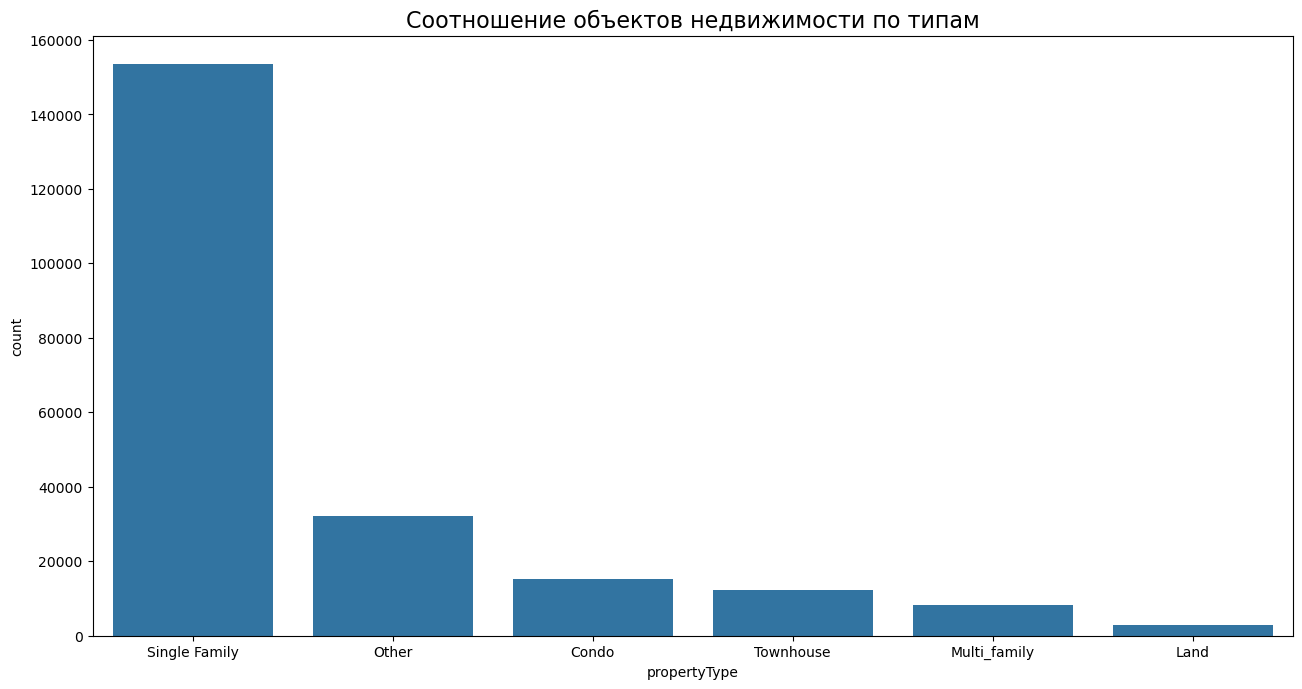

In [51]:
fig = plt.figure(figsize=(12, 6))
axes = fig.add_axes((1, 1, 1, 1))
data_type = data['propertyType'].value_counts().sort_values(ascending=False)
sns.barplot(data_type,ax = axes)
title = axes.set_title('Соотношение объектов недвижимости по типам', fontsize=16)

Из графика можно сдлеать вывод, что основную долю занимает недвижимость для семей с одним, двумя детьми или без детей.

#### 2. Построим график, показывающий наличие бассейна по типам недвижимости.

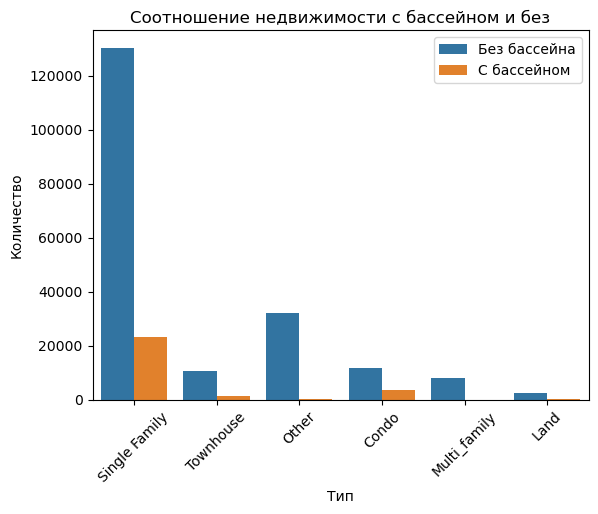

In [52]:
ax = sns.countplot(data=data, x=data['propertyType'], hue='pool')
ax.set(xlabel='Тип', ylabel='Количество')
ax.xaxis.set_tick_params(rotation=45)
plt.title('Соотношение недвижимости с бассейном и без')
ax.legend(['Без бассейна', 'С бассейном'])

Из графика можно сделать вывод, что бассейны чаще всего встречаются в недвижимости для малосемейных.

#### 2_1. Построим график, показывающий наличие камина по типам недвижимости.

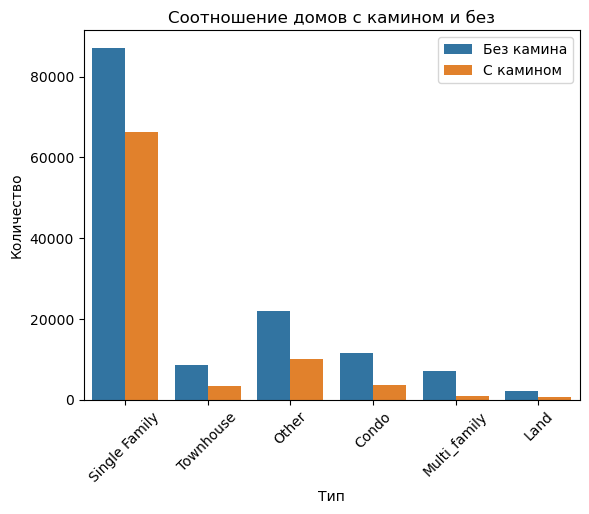

In [53]:
ax = sns.countplot(data=data, x=data['propertyType'], hue='fireplace')
ax.set(xlabel='Тип', ylabel='Количество')
ax.xaxis.set_tick_params(rotation=45)
plt.title('Соотношение домов с камином и без')
ax.legend(['Без камина', 'С камином'])

Из графика можно сделать вывод, что камины чаще всего встречаются в недвижимости для малосемейных.

#### 2_2. Построим график, показывающий наличие парковочного места по типам недвижимости.

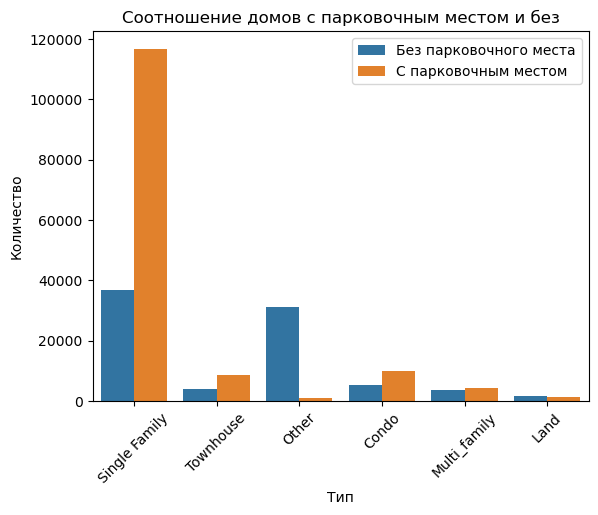

In [54]:
ax = sns.countplot(data=data, x=data['propertyType'], hue='parking')
ax.set(xlabel='Тип', ylabel='Количество')
ax.xaxis.set_tick_params(rotation=45)
plt.title('Соотношение домов с парковочным местом и без')
ax.legend(['Без парковочного места', 'С парковочным местом'])

Из графика можно сделать вывод, что парковочные места преоблатают у всех типов недвижимости, за исключением категории другие.

#### 3. Построим диаграмму, показывающую зависимость стоимости объекта недвижимости в зависимости от типа.

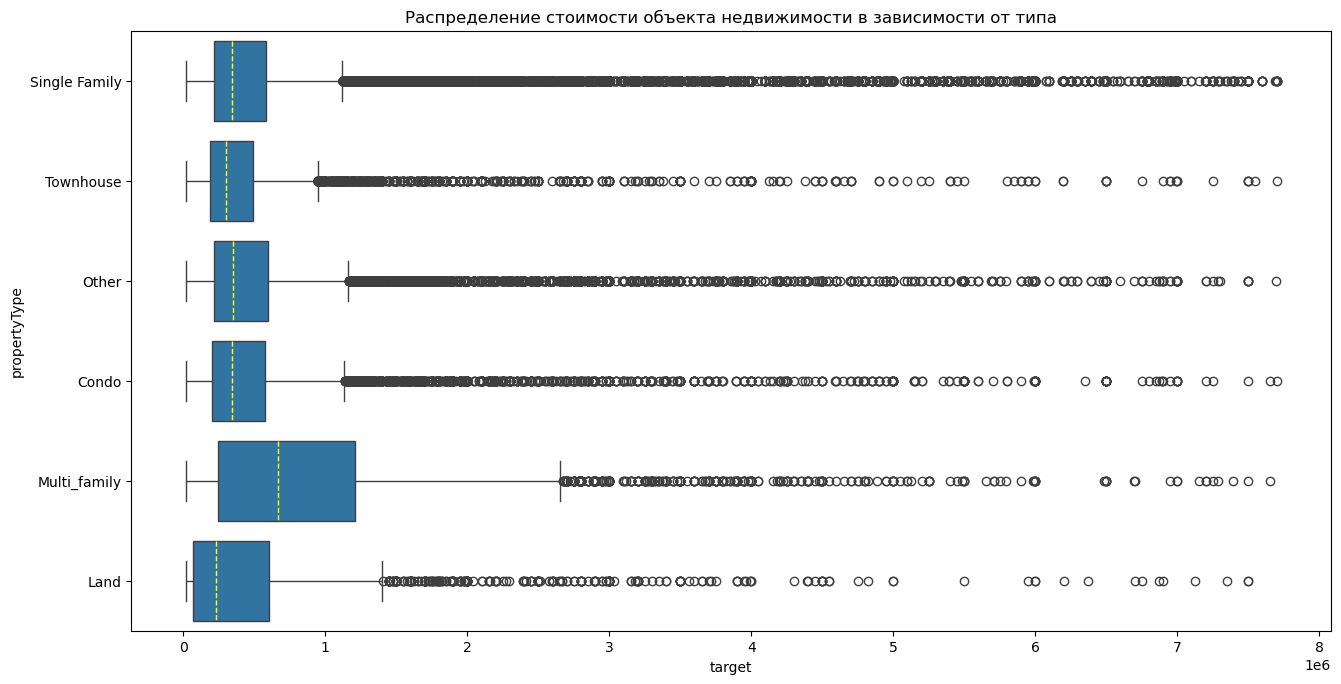

In [55]:
fig = plt.figure(figsize=(12, 6))
axes = fig.add_axes((1, 1, 1, 1))
sns.boxplot(data, x='target', y='propertyType', orient='h', medianprops={"color": "yellow", "linestyle": '--'},ax = axes)
ax.set(xlabel='Стоимость', ylabel='Тип')
plt.title('Распределение стоимости объекта недвижимости в зависимости от типа');

Медианная стоимость у всех объектов недвижимости находится почти на огдном уровне, но наблюдается довольно сильный разброс значений.

#### 4. Построим график, отображающий стоимость недвижимости в зависимости от типа.

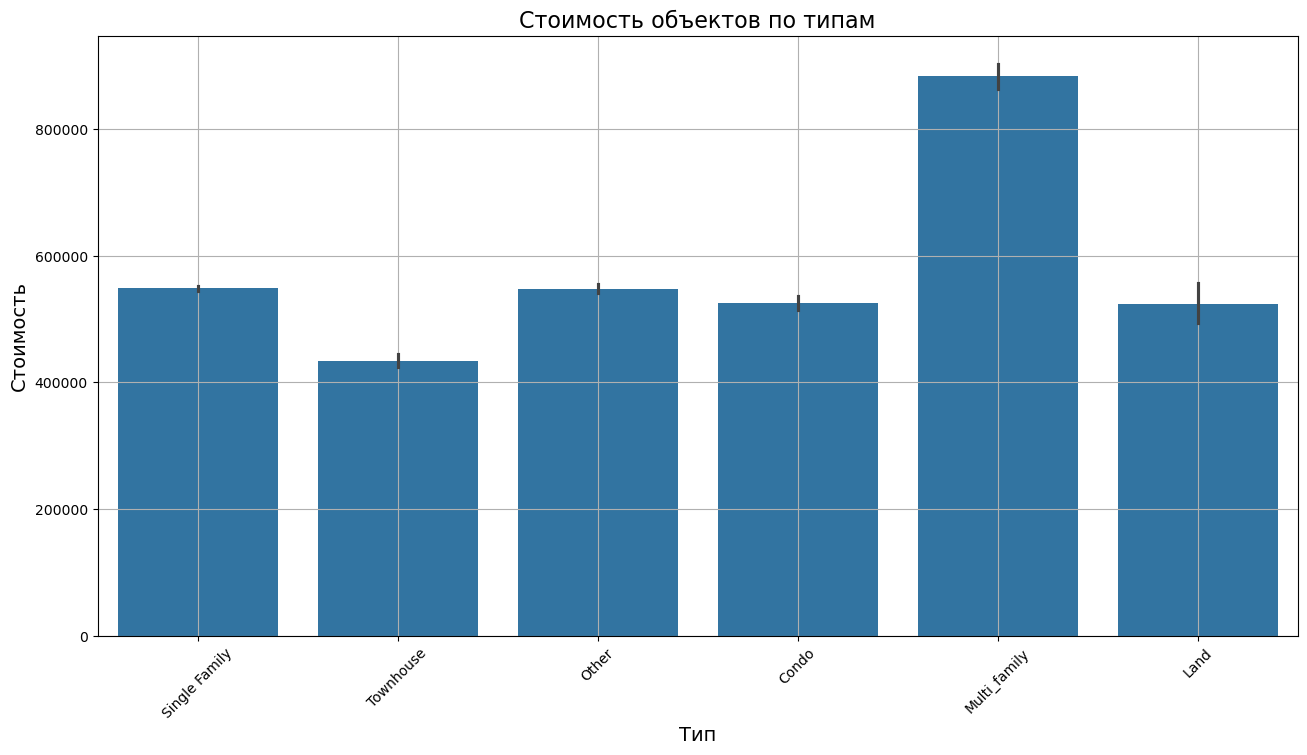

In [56]:
fig = plt.figure(figsize=(12, 6))
axes = fig.add_axes((1, 1, 1, 1))
sns.barplot(
    data=data,
    x='propertyType',
    y='target',
    orient='v',
    ax = axes,
)
axes.tick_params(axis='x', rotation=45);
axes.set_title('Стоимость объектов по типам', fontsize=16);
axes.set_xlabel('Тип', fontsize=14);
axes.set_ylabel('Стоимость', fontsize=14);
axes.grid()

Из графика можно сделать вывод, что наибольшую стоимость имеет недвижимость для многодетных..

#### 5. Построим график показывающий количество лотов по штатам.

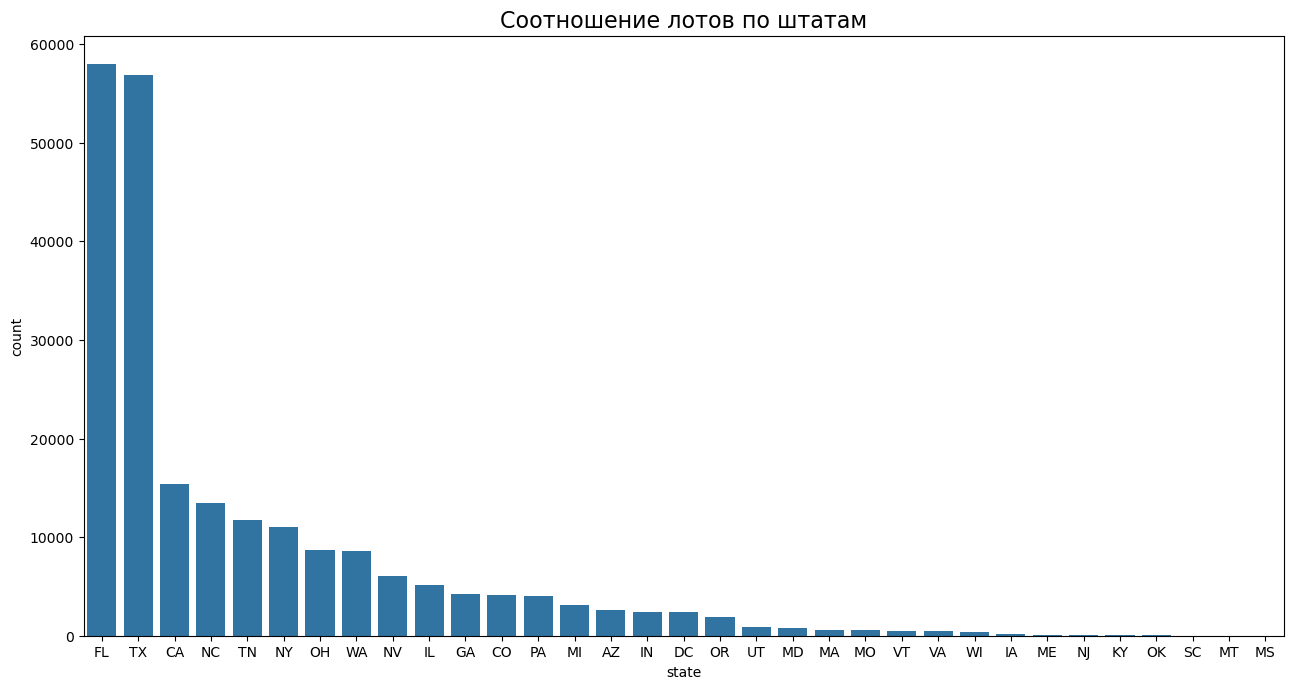

In [57]:
fig = plt.figure(figsize=(12, 6))
axes = fig.add_axes((1, 1, 1, 1))
data_state = data['state'].value_counts().sort_values(ascending=False)
sns.barplot(data_state,ax = axes)
title = axes.set_title('Соотношение лотов по штатам', fontsize=16)

Наибольшее количество объектов недвижимости находится в штатах Флорида и Техас

#### 6. Построим график показывающий стоимость недвижимости по штатам.

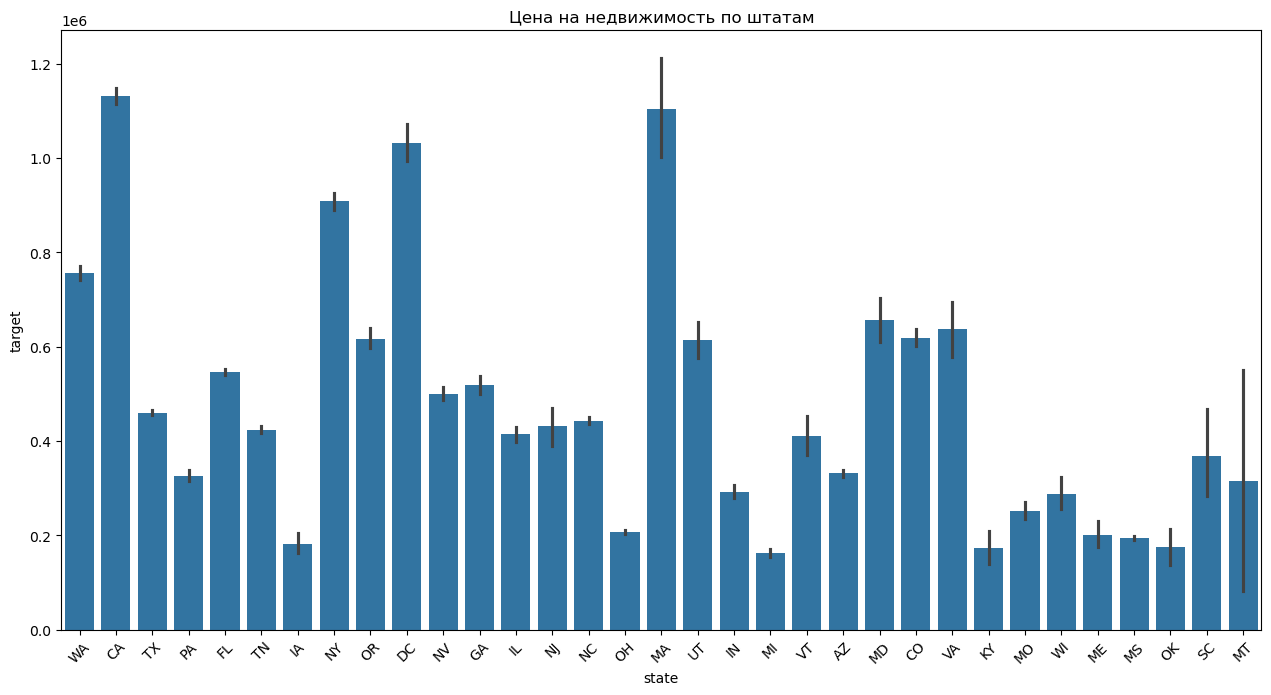

In [58]:
fig = plt.figure(figsize=(12, 6))
axes = fig.add_axes((1, 1, 1, 1))
sns.barplot(data=data, x='state',y='target')
axes.xaxis.set_tick_params(rotation=45)
plt.title('Цена на недвижимость по штатам');

Самая высокая стоимость недвижимости в штате Калифорния

#### 7.Построим график показывающий средний возраст объектов по типам.

<Axes: xlabel='propertyType', ylabel='age_building'>

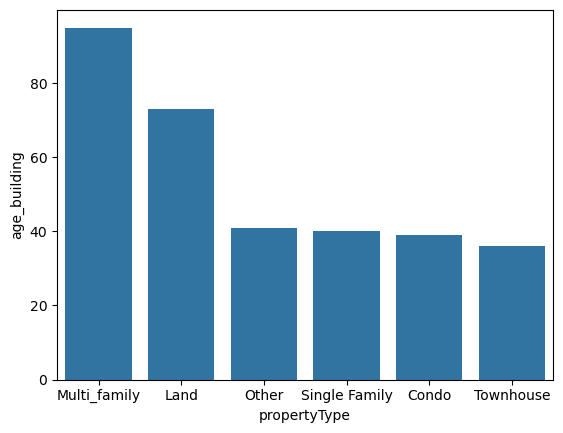

In [59]:
age_mean = data.groupby('propertyType')['age_building'].median().sort_values(ascending = False)

sns.barplot(age_mean)

Наиболее старые объекты принадлежат к строениям для многосемейных.

#### 8.Построим график показывающий среднюю стоимость квадратного фута в зависимости от типа.

<Axes: xlabel='propertyType', ylabel='price'>

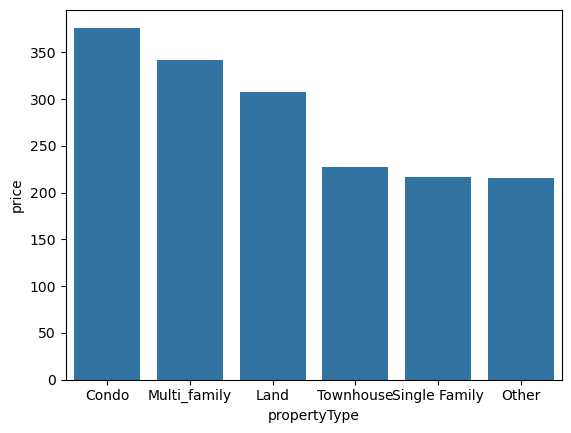

In [60]:
price_type = data.groupby('propertyType')['price'].mean().sort_values(ascending = False)

sns.barplot(price_type)

Самым дорогим типом недвижимости оказались квартиры

Построим матрицу корреляции, а также тепловую карту на её основе.

In [61]:
df_numeric = data.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['baths' 'fireplace' 'sqft' 'beds' 'target' 'pool' 'heating' 'cooling'
 'parking' 'lotsize' 'price' 'age_building' 'distance_to_schools_avg'
 'school_count' 'schools_rating_avg']


,index,target
4,target,1.000000
10,price,0.685555
2,sqft,0.593292
3,beds,0.327684
14,schools_rating_avg,0.258018
5,pool,0.199403
1,fireplace,0.131711
8,parking,0.062630
0,baths,0.050535
12,distance_to_schools_avg,0.007040


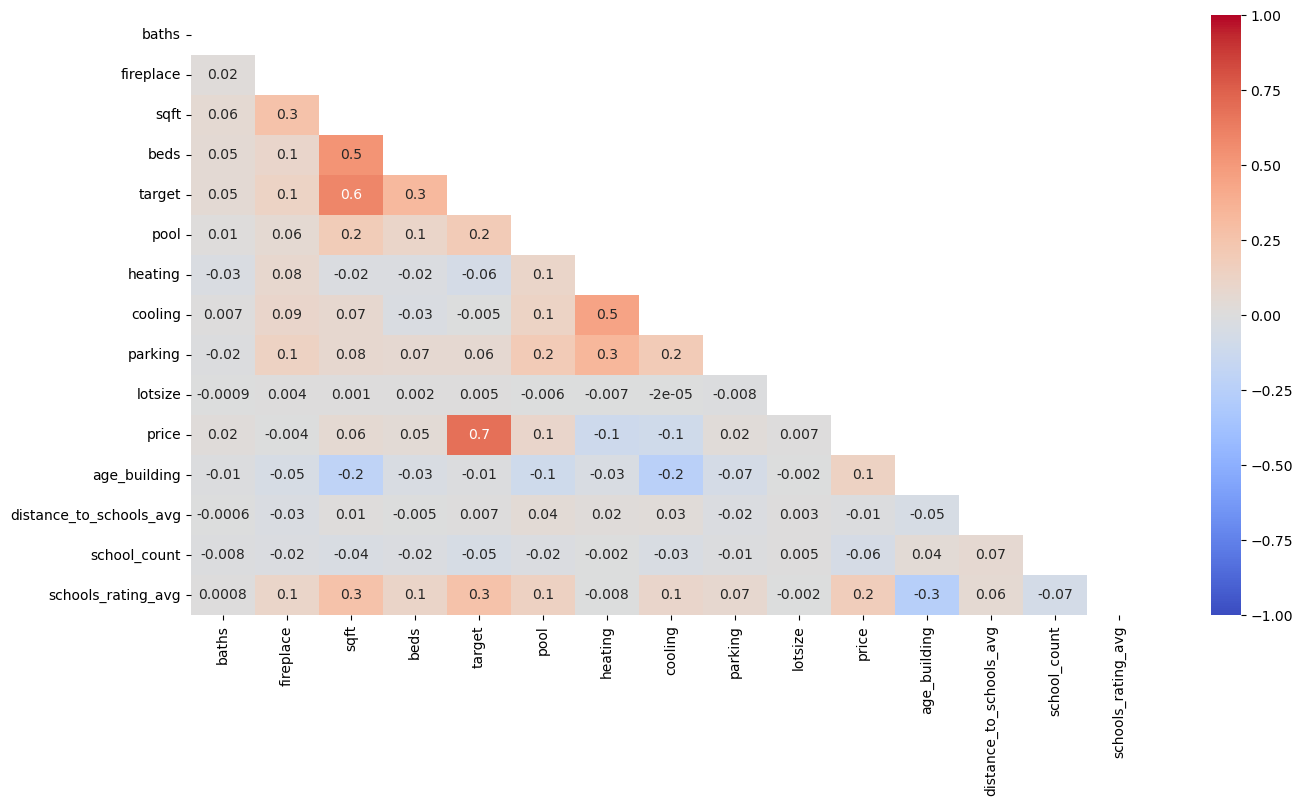

In [62]:
corr = data[numeric_cols].corr()
matrix = np.triu(corr)

fig = plt.figure(figsize=(12, 6))
axes = fig.add_axes((1, 1, 1, 1))
sns.heatmap(corr, annot=True, fmt ='.1g',vmin=-1, vmax=1, center=0, mask=matrix,ax=axes,cmap= 'coolwarm')

corr = corr['target'].reset_index()
corr = corr.sort_values('target', ascending=False)
corr

Между признаками price и target наблюдается положительная корреляция, возможно перед нами утечка данных.

Кодируем категориальные признаки OneHot кодированием

In [63]:
columns_to_change = ['propertyType', 'state', 'status']
encoder = preprocessing.OneHotEncoder(drop='first') 
data_onehot = encoder.fit_transform(data[columns_to_change]).toarray()
# Получаем закодированные имена столбцов
column_names = encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
df = pd.DataFrame(data_onehot, columns=column_names)
data = pd.concat(
    [data.reset_index(drop=True).drop(columns_to_change, axis=1), df], 
    axis=1)

data.head()

,baths,fireplace,sqft,beds,target,pool,heating,cooling,parking,lotsize,...,state_WA,state_WI,status_back changes,status_coming soon,status_contract,status_for sale,status_foreclosure,status_new,status_other,status_pending
0,3.000000,0,1947.0,3.000000,310000.0,0,0,0,0,5828.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2.000000,1,3000.0,3.000000,2895000.0,1,1,1,1,8626.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,8.000000,1,6457.0,5.000000,2395000.0,0,1,1,1,8220.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.463623,0,897.0,2.000000,209000.0,0,1,1,0,680.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3.463623,0,1507.0,3.349547,181500.0,0,1,1,0,4996.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Разделяем набор данных на матрицу наблюдений X и столбец правильных ответов y.

In [64]:
X = data.drop('target',axis=1)
y = data['target']

Разделим всю выборку на тренировочную и тестовую в соотношении 70/30.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

Производим нормализацию данных

In [66]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### **Постройка модели и оценка метрик.**

Цель- построить модель, решающую поставленную задачу и оценить ее качество

Будем оценивать модель с помощью следующих метрик:

1. $R^2$ - коэффициент детерминации
2. MAE - средняя абсолютная ошибка (целевая метрика)
3. MAPE - средняя абсолютная ошибка в процентах

Объявим функцию для вывода значений метрик

In [67]:
def get_metrics(y_train, y_train_pred, y_test, y_test_pred):
    print('R2 for train: {:.3f}'.format(metrics.r2_score(y_train,y_train_pred)))
    print('MAE for train: {:.3f}'.format(metrics.mean_absolute_error(y_train,y_train_pred)))
    print('MAPE for train: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train,y_train_pred)*100))
    print('\n')
    print('R2 for test: {:.3f}'.format(metrics.r2_score(y_test,y_test_pred)))
    print('MAE for test: {:.3f}'.format(metrics.mean_absolute_error(y_test,y_test_pred)))
    print('MAPE for test: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train,y_train_pred)*100))

В качестве baseline будем использовать простую модель линейной регрессии.

In [68]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)
#Выводим результирующие метрики
get_metrics(y_train, y_train_pred, y_test, y_test_pred)

R2 for train: 0.780
MAE for train: 159064.857
MAPE for train: 59.892


R2 for test: 0.790
MAE for test: 159345.197
MAPE for test: 59.892


Попробуем улучшить значения метрик.

Логарифмируем целевой признак.

In [69]:
#Создаем логарифмированный целевой признак
y_train_log = np.log(y_train)
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train_scaled, y_train_log)
#Делаем предсказание для каждой из выборок
## Так как обучали на логарифме, необходимо проэкспонировать
y_train_pred = np.exp(lr.predict(X_train_scaled))
y_test_pred = np.exp(lr.predict(X_test_scaled))
#Выводим результирующие метрики
get_metrics(y_train, y_train_pred, y_test, y_test_pred)

R2 for train: -844335323362735616.000
MAE for train: 1645770017573.105
MAPE for train: 25317794.748


R2 for test: -13823.472
MAE for test: 986519.448
MAPE for test: 25317794.748


Применим модель построенную на деревьях решений.

In [70]:
# Инициализируем модель дерева решений с максимальной глубиной 5 и обучаем ее
dt = tree.DecisionTreeRegressor(
    max_depth=5, #глубина
    criterion='squared_error', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем модель
dt.fit(X_train_scaled, y_train_log)

#Делаем предсказание для каждой из выборок
## Так как обучали на логарифме, необходимо проэкспонировать
y_train_pred = np.exp(dt.predict(X_train_scaled))
y_test_pred = np.exp(dt.predict(X_test_scaled)) 
#Выводим результирующие метрики
get_metrics(y_train, y_train_pred, y_test, y_test_pred)

R2 for train: 0.863
MAE for train: 105767.975
MAPE for train: 17.866


R2 for test: 0.860
MAE for test: 106427.791
MAPE for test: 17.866


Модель построеная на дереве решений, с не самыми большими показателями глубины, даёт результаты значительно лучшие, чем модель линейной регрессии.

Используем модель случайного леса.

In [71]:
# Создаем модель случайного леса из 10 деревьев с максимальной глубиной 10 для каждого дерева
rf_model = ensemble.RandomForestRegressor(
    max_depth=10,
    n_estimators=10,
    random_state=42
)
# Обучаем модель
rf_model.fit(X_train_scaled,y_train_log)
#Делаем предсказание для каждой из выборок
## Так как обучали на логарифме, необходимо проэкспонировать
y_train_pred = np.exp(rf_model.predict(X_train_scaled))
y_test_pred = np.exp(rf_model.predict(X_test_scaled))
#Выводим результирующие метрики
get_metrics(y_train, y_train_pred, y_test, y_test_pred)

R2 for train: 0.997
MAE for train: 11144.155
MAPE for train: 1.752


R2 for test: 0.996
MAE for test: 12350.186
MAPE for test: 1.752


Выполним подбор оптимальных параметров, для модели случайного леса, с помощью RandomizeSearch.

In [72]:
params = {
    'n_estimators':list(range(10,50,5)),
    'min_samples_leaf':list(range(1,10,1)),
    'max_depth':list(np.linspace(10,40,10,dtype=int))
}

rs_forest = RandomizedSearchCV(
    estimator = ensemble.RandomForestRegressor(random_state=42),
    param_distributions = params,
    cv = 5,
    n_iter = 10,
    n_jobs = -1
)

rs_forest.fit(X_train_scaled,y_train_log)

y_train_pred = np.exp(rs_forest.predict(X_train_scaled))
y_test_pred = np.exp(rs_forest.predict(X_test_scaled))

get_metrics(y_train, y_train_pred, y_test, y_test_pred)
print("Наилучшие значения гиперпараметров: {}".format(rs_forest.best_params_))

R2 for train: 1.000
MAE for train: 1459.368
MAPE for train: 0.221


R2 for test: 0.999
MAE for test: 3640.866
MAPE for test: 0.221
Наилучшие значения гиперпараметров: {'n_estimators': 45, 'min_samples_leaf': 1, 'max_depth': 40}


Выясним значимость признаков.

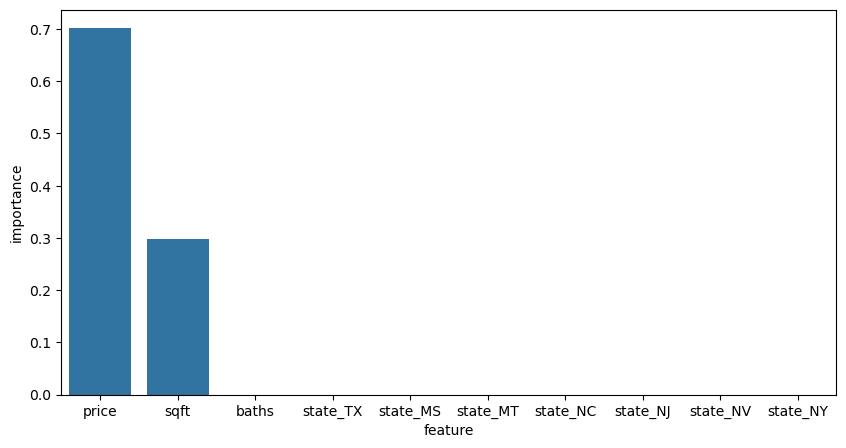

In [73]:
fig,ax = plt.subplots(figsize=(10,5))
features = X.columns
feature_importances = dt.feature_importances_

importances_df = pd.DataFrame({
    'feature':features,
    'importance':feature_importances
})
importances_df.sort_values(by='importance',ascending=False,inplace=True)

sns.barplot(data=importances_df[:10], y='importance', x='feature', ax=ax);

Наибольшее влияние на результат оказывает признак 'price'. Это можно расценивать как утечку. Удалим данный признак.

In [74]:
X = data.drop(['price','target'],axis=1)
y = data['target']

Разделяем всю выборку на тренировочную и тестовую в соотношении 70/30.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

Нормализуем данные и подбираем парметры с помощью RandomizeSearch.

In [76]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
params = {
    'n_estimators': list(range(10, 50, 5)),
    'min_samples_leaf': list(range(1, 10, 1)),
    'max_depth': list(np.linspace(10, 40, 10, dtype=int))
}

rs_forest = RandomizedSearchCV(
    estimator = ensemble.RandomForestRegressor(random_state=42),
    param_distributions = params,
    cv = 5,
    n_iter = 10,
    n_jobs = -1
)

rs_forest.fit(X_train_scaled,y_train_log)

y_train_pred = np.exp(rs_forest.predict(X_train_scaled))
y_test_pred = np.exp(rs_forest.predict(X_test_scaled))

get_metrics(y_train, y_train_pred, y_test, y_test_pred)
print("Наилучшие значения гиперпараметров: {}".format(rs_forest.best_params_))

R2 for train: 0.807
MAE for train: 118504.756
MAPE for train: 20.789


R2 for test: 0.683
MAE for test: 167062.481
MAPE for test: 20.789
Наилучшие значения гиперпараметров: {'n_estimators': 45, 'min_samples_leaf': 5, 'max_depth': 36}


Отберём 30 признаков, дающих наибольший вклад, с помощью KBest.

In [78]:
feature_select = SelectKBest(k=30)
X_train = X_train.select_dtypes([np.number])
feature_select.fit(X_train, y_train)
columns_kbest = feature_select.get_feature_names_out()
print(columns_kbest)

['fireplace' 'sqft' 'beds' 'pool' 'heating' 'cooling' 'parking'
 'age_building' 'distance_to_schools_avg' 'school_count'
 'schools_rating_avg' 'state_CA' 'state_CO' 'state_DC' 'state_FL'
 'state_IA' 'state_IL' 'state_MI' 'state_NC' 'state_NV' 'state_NY'
 'state_OH' 'state_OR' 'state_SC' 'state_TX' 'state_VA' 'state_WA'
 'status_foreclosure' 'status_new' 'status_pending']


Выделяем отобранные признаки из общего числа признаков.

In [79]:
X_kbest = data[columns_kbest]
y_kbest = data['target']

Разбиваем выборку на тренировочную и тестовую в соотношении 70/30.

In [80]:
X_train_kbest, X_test_kbest, y_train_kbest, y_test_kbest = train_test_split(X_kbest, y_kbest, test_size=0.3, random_state=42)

Проводим нормализацию.

In [81]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_kbest)
X_train_kbest_scaled = scaler.transform(X_train_kbest)
X_test_kbest_scaled = scaler.transform(X_test_kbest)

Воспользуемся библиотекой OPTUNA для подбора гиперпараметров.

In [82]:
#Создаем логарифмированный целевой признак
y_train_kbest_log = np.log(y_train_kbest)
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 10, 200, 10)
  max_depth = trial.suggest_int('max_depth', 5, 50, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
  # создаем модель
  model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_kbest_scaled, y_train_kbest_log)
  score = metrics.mean_absolute_percentage_error(y_train_kbest, np.exp(model.predict(X_train_kbest_scaled)))*100
  return score

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestRegressor", direction='minimize')
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.3f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(**study.best_params,random_state=42)
model.fit(X_train_kbest_scaled, y_train_kbest_log)
y_train_kbest_pred = np.exp(model.predict(X_train_kbest_scaled))
y_test_kbest_pred = np.exp(model.predict(X_test_kbest_scaled))
print('MAPE на тестовом наборе: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test_kbest, y_test_kbest_pred)*100))

[I 2025-04-07 15:05:10,058] A new study created in memory with name: RandomForestRegressor
[I 2025-04-07 15:07:51,803] Trial 0 finished with value: 18.19877324174923 and parameters: {'n_estimators': 200, 'max_depth': 49, 'min_samples_leaf': 3}. Best is trial 0 with value: 18.19877324174923.
[I 2025-04-07 15:08:06,718] Trial 1 finished with value: 23.68892649196552 and parameters: {'n_estimators': 20, 'max_depth': 40, 'min_samples_leaf': 5}. Best is trial 0 with value: 18.19877324174923.
[I 2025-04-07 15:09:21,139] Trial 2 finished with value: 38.302815013400334 and parameters: {'n_estimators': 150, 'max_depth': 13, 'min_samples_leaf': 10}. Best is trial 0 with value: 18.19877324174923.
[I 2025-04-07 15:10:31,721] Trial 3 finished with value: 42.81424159911283 and parameters: {'n_estimators': 180, 'max_depth': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: 18.19877324174923.
[I 2025-04-07 15:11:43,718] Trial 4 finished with value: 34.85813188201596 and parameters: {'n_estimator

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 49, 'min_samples_leaf': 3}
MAPE на обучающем наборе: 18.199
MAPE на тестовом наборе: 33.592


In [83]:
# продолжим подбор еще 10 итераций 
study.optimize(optuna_rf, n_trials=10)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.3f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(**study.best_params,random_state=42)
model.fit(X_train_kbest_scaled, y_train_kbest_log)
y_train_kbest_pred = np.exp(model.predict(X_train_kbest_scaled))
y_test_kbest_pred = np.exp(model.predict(X_test_kbest_scaled))
print('MAPE на тестовом наборе: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test_kbest, y_test_kbest_pred)*100))

[I 2025-04-07 15:24:13,846] Trial 10 finished with value: 13.863577177040257 and parameters: {'n_estimators': 200, 'max_depth': 29, 'min_samples_leaf': 1}. Best is trial 10 with value: 13.863577177040257.
[I 2025-04-07 15:26:59,582] Trial 11 finished with value: 14.563307768591127 and parameters: {'n_estimators': 200, 'max_depth': 28, 'min_samples_leaf': 1}. Best is trial 10 with value: 13.863577177040257.
[I 2025-04-07 15:29:49,115] Trial 12 finished with value: 15.369336716768789 and parameters: {'n_estimators': 200, 'max_depth': 27, 'min_samples_leaf': 1}. Best is trial 10 with value: 13.863577177040257.
[I 2025-04-07 15:32:14,045] Trial 13 finished with value: 16.30418678198614 and parameters: {'n_estimators': 180, 'max_depth': 26, 'min_samples_leaf': 1}. Best is trial 10 with value: 13.863577177040257.
[I 2025-04-07 15:33:28,693] Trial 14 finished with value: 18.471445850074293 and parameters: {'n_estimators': 100, 'max_depth': 34, 'min_samples_leaf': 3}. Best is trial 10 with val

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 29, 'min_samples_leaf': 1}
MAPE на обучающем наборе: 13.864
MAPE на тестовом наборе: 33.257


Построим график истории оптимизации - он отображает количество испытаний на оси Х и метрику на оси Y.

In [84]:
optuna.visualization.plot_optimization_history(study, target_name="MAPE")

Из графика видно, что метрика минимизируется.

Постороим график важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию метрики.

In [85]:
optuna.visualization.plot_param_importances(study, target_name="MAPE")

Из графика можно сделвать вывод, что стоит обратить большее внимание на настройку гиперпараметра max_depth

Исходя из метрик можно сделать вывод, что значения метрик лучше на полном наборе данных, без отбора признаков.

Проведем подбор гиперпараметров с помощью OPTUNA для полного набора признаков.

Разделим набор данных на матрицу наблюдений X (таблица из объектов и их признаков без учета признака price) и столбец правильных ответов y

In [86]:
X = data.drop(['price','target'], axis=1)
y = data['target']

Делим выборку на обучающую и тестовую в соотношении 70/30

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Проводим нормализацию.

In [88]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Подбираем гиперпараметры с помощью OPTUNA

In [89]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 10, 200, 10)
  max_depth = trial.suggest_int('max_depth', 5, 50, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
  # создаем модель
  model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train_log)
  score = metrics.mean_absolute_percentage_error(y_train, np.exp(model.predict(X_train_scaled)))*100
  return score

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestRegressor", direction='minimize')
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.3f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train_log)
y_train_pred = np.exp(model.predict(X_train_scaled))
y_test_pred = np.exp(model.predict(X_test_scaled))
print('MAPE на тестовом наборе: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)*100))

[I 2025-04-07 15:45:10,780] A new study created in memory with name: RandomForestRegressor
[I 2025-04-07 15:49:03,619] Trial 0 finished with value: 20.678864179484954 and parameters: {'n_estimators': 190, 'max_depth': 33, 'min_samples_leaf': 5}. Best is trial 0 with value: 20.678864179484954.
[I 2025-04-07 15:50:34,518] Trial 1 finished with value: 25.493735775674477 and parameters: {'n_estimators': 80, 'max_depth': 45, 'min_samples_leaf': 9}. Best is trial 0 with value: 20.678864179484954.
[I 2025-04-07 15:51:57,685] Trial 2 finished with value: 23.499691829383465 and parameters: {'n_estimators': 70, 'max_depth': 45, 'min_samples_leaf': 7}. Best is trial 0 with value: 20.678864179484954.
[I 2025-04-07 15:54:35,258] Trial 3 finished with value: 37.16715094497826 and parameters: {'n_estimators': 200, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 0 with value: 20.678864179484954.
[I 2025-04-07 15:57:27,128] Trial 4 finished with value: 22.250927781074903 and parameters: {'n_esti

Наилучшие значения гиперпараметров {'n_estimators': 150, 'max_depth': 45, 'min_samples_leaf': 1}
MAPE на обучающем наборе: 10.298
MAPE на тестовом наборе: 29.805


In [90]:
# продолжим подбор еще 10 итераций 
study.optimize(optuna_rf, n_trials=10)

[I 2025-04-07 16:12:19,997] Trial 10 finished with value: 34.863771635414196 and parameters: {'n_estimators': 130, 'max_depth': 13, 'min_samples_leaf': 1}. Best is trial 8 with value: 10.297576176045261.
[I 2025-04-07 16:12:55,056] Trial 11 finished with value: 19.24800183873241 and parameters: {'n_estimators': 30, 'max_depth': 23, 'min_samples_leaf': 1}. Best is trial 8 with value: 10.297576176045261.
[I 2025-04-07 16:15:03,591] Trial 12 finished with value: 16.08504304334174 and parameters: {'n_estimators': 110, 'max_depth': 41, 'min_samples_leaf': 3}. Best is trial 8 with value: 10.297576176045261.
[I 2025-04-07 16:18:35,496] Trial 13 finished with value: 13.067420861667097 and parameters: {'n_estimators': 170, 'max_depth': 38, 'min_samples_leaf': 2}. Best is trial 8 with value: 10.297576176045261.
[I 2025-04-07 16:20:14,683] Trial 14 finished with value: 24.661929359594822 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 8 with value: 10.

In [91]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("MAPE на обучающем наборе: {:.3f} %".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train_log)
y_train_pred = np.exp(model.predict(X_train_scaled))
y_test_pred = np.exp(model.predict(X_test_scaled))
print('MAPE на тестовом наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)*100))

Наилучшие значения гиперпараметров {'n_estimators': 150, 'max_depth': 45, 'min_samples_leaf': 1}
MAPE на обучающем наборе: 10.298 %
MAPE на тестовом наборе: 29.805 %


Попробуем применить алгоритмы градиентного бустинга.

In [92]:
cb = CatBoostRegressor(random_state=42, iterations=200)
#Обучаем модель
cb.fit(X_train_scaled, y_train_log)

#Делаем предсказание для тренировочной выборки
y_train_pred_cb = np.exp(cb.predict(X_train_scaled))
#Выводим значение метрики MAPE для тренировочной выборки
print('Train MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred_cb)*100))
#Делаем предсказание для тестовой выборки
y_test_pred_cb = np.exp(cb.predict(X_test_scaled))
#Выводим значение метрики MAPE для тестовой выборки
print('Test MAPE: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred_cb)*100))
print("Наилучшие значения гиперпарметров: {}".format(cb.get_params()))

Learning rate set to 0.336784
0:	learn: 0.7615909	total: 156ms	remaining: 31s
1:	learn: 0.6869642	total: 171ms	remaining: 16.9s
2:	learn: 0.6407657	total: 187ms	remaining: 12.3s
3:	learn: 0.6092508	total: 201ms	remaining: 9.86s
4:	learn: 0.5881224	total: 217ms	remaining: 8.45s
5:	learn: 0.5713138	total: 228ms	remaining: 7.36s
6:	learn: 0.5579227	total: 240ms	remaining: 6.63s
7:	learn: 0.5483133	total: 254ms	remaining: 6.1s
8:	learn: 0.5409766	total: 266ms	remaining: 5.64s
9:	learn: 0.5344746	total: 277ms	remaining: 5.27s
10:	learn: 0.5268331	total: 291ms	remaining: 5.01s
11:	learn: 0.5205573	total: 303ms	remaining: 4.75s
12:	learn: 0.5152914	total: 316ms	remaining: 4.54s
13:	learn: 0.5120707	total: 327ms	remaining: 4.34s
14:	learn: 0.5086632	total: 338ms	remaining: 4.17s
15:	learn: 0.5041553	total: 351ms	remaining: 4.03s
16:	learn: 0.4989220	total: 360ms	remaining: 3.87s
17:	learn: 0.4947134	total: 370ms	remaining: 3.74s
18:	learn: 0.4907597	total: 383ms	remaining: 3.65s
19:	learn: 0.4

Так как значения метрик на тестовой выборке при использовании бустинга получаются чуть хуже значений метрики без использования бустинга остановимся на модели на основе Случайного леса с подбором оптимальных параметров с помощью OPTUNA.

Воспользуемся разбиением исходного набора данных на обучающую, валидационную и тестовую выборки.

Обучение будем производить на обучающем наборе данных, подбор параметров будем делать с помощью валидационной выборки, а оценивать результат подбора будем на тестовой выборке.

In [93]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 70/30
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

Произведём нормализацию.

In [94]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

Логарифмируем целевую переменную.

In [95]:
y_train_log = np.log(y_train)
y_valid_log = np.log(y_valid)

In [96]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 10, 200, 10)
  max_depth = trial.suggest_int('max_depth', 5, 50, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
  # создаем модель
  model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train_log)
  score = metrics.mean_absolute_percentage_error(y_valid, np.exp(model.predict(X_valid_scaled)))*100
  return score

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestRegressor", direction='minimize')
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

# выводим результаты на валидационной выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("MAPE на тренировочном наборе: {:.3f} %".format(metrics.mean_absolute_percentage_error(y_train, np.exp(model.predict(X_train_scaled)))*100))
print("MAPE на валидационном наборе: {:.3f} %".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestRegressor(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train_log)
y_valid_pred = np.exp(model.predict(X_valid_scaled))
y_test_pred = np.exp(model.predict(X_test_scaled))
print('MAPE на тестовом наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)*100))

[I 2025-04-07 16:33:27,982] A new study created in memory with name: RandomForestRegressor
[I 2025-04-07 16:36:54,415] Trial 0 finished with value: 32.71447869526169 and parameters: {'n_estimators': 200, 'max_depth': 24, 'min_samples_leaf': 5}. Best is trial 0 with value: 32.71447869526169.
[I 2025-04-07 16:37:36,348] Trial 1 finished with value: 32.875192731498814 and parameters: {'n_estimators': 40, 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 0 with value: 32.71447869526169.
[I 2025-04-07 16:39:49,344] Trial 2 finished with value: 32.00801710047827 and parameters: {'n_estimators': 120, 'max_depth': 33, 'min_samples_leaf': 5}. Best is trial 2 with value: 32.00801710047827.
[I 2025-04-07 16:42:05,027] Trial 3 finished with value: 31.54848550628303 and parameters: {'n_estimators': 120, 'max_depth': 39, 'min_samples_leaf': 4}. Best is trial 3 with value: 31.54848550628303.
[I 2025-04-07 16:42:37,539] Trial 4 finished with value: 49.32051361158255 and parameters: {'n_estimators

Наилучшие значения гиперпараметров {'n_estimators': 130, 'max_depth': 48, 'min_samples_leaf': 3}
MAPE на тренировочном наборе: 10.298 %
MAPE на валидационном наборе: 31.135 %
MAPE на тестовом наборе: 29.972 %


In [97]:
# продолжим подбор еще 10 итераций 
study.optimize(optuna_rf, n_trials=10)

[I 2025-04-07 16:56:55,407] Trial 10 finished with value: 33.446502594644464 and parameters: {'n_estimators': 160, 'max_depth': 50, 'min_samples_leaf': 10}. Best is trial 8 with value: 31.13531248803585.
[I 2025-04-07 16:59:24,748] Trial 11 finished with value: 31.527734499238942 and parameters: {'n_estimators': 130, 'max_depth': 49, 'min_samples_leaf': 4}. Best is trial 8 with value: 31.13531248803585.
[I 2025-04-07 17:02:56,666] Trial 12 finished with value: 30.308317836596377 and parameters: {'n_estimators': 150, 'max_depth': 49, 'min_samples_leaf': 1}. Best is trial 12 with value: 30.308317836596377.
[I 2025-04-07 17:06:28,386] Trial 13 finished with value: 30.308742571576264 and parameters: {'n_estimators': 150, 'max_depth': 43, 'min_samples_leaf': 1}. Best is trial 12 with value: 30.308317836596377.
[I 2025-04-07 17:10:13,739] Trial 14 finished with value: 30.301116647494293 and parameters: {'n_estimators': 160, 'max_depth': 42, 'min_samples_leaf': 1}. Best is trial 14 with value

In [98]:
# выводим результаты
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

# рассчитаем точность для тестовой выборки
best_model = ensemble.RandomForestRegressor(**study.best_params,random_state=42)
best_model.fit(X_train_scaled, y_train_log)
y_train_pred = np.exp(best_model.predict(X_train_scaled))
y_valid_pred = np.exp(best_model.predict(X_valid_scaled))
y_test_pred = np.exp(best_model.predict(X_test_scaled))
print('MAPE на обучающем наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)*100))
print('MAPE на валидационном  наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_valid, y_valid_pred)*100))
print('MAPE на тестовом наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)*100))

Наилучшие значения гиперпараметров {'n_estimators': 170, 'max_depth': 43, 'min_samples_leaf': 1}
MAPE на обучающем наборе: 10.310 %
MAPE на валидационном  наборе: 30.283 %
MAPE на тестовом наборе: 29.273 %


Записываем модель с оптимальными параметрами в файл.

In [99]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('web/app/models/model.pkl','wb') as output:
    pickle.dump(best_model, output)